# Setup

In [40]:
import torchaudio
import noisereduce as nr
import torch as tr
import numpy as np
import matplotlib.pyplot as plt

In [41]:
x1, sr = torchaudio.load('../data/sensor_1.wav')
x2, sr = torchaudio.load('../data/sensor_2.wav')
x3, sr = torchaudio.load('../data/sensor_3.wav')
X = tr.concat([x1, x2, x3], dim=0)

N = len(x1[0])
n = 3
tt = tr.arange(N) / sr
ii = tr.linspace(0, N, n, dtype=tr.int32)

In [42]:
def long_or(a, w):
    w = int(w)
    y = tr.zeros(a.shape)
    for i in range(w, a.shape[0]-w , w//4):
        y[i-w:i+w] = True in a[i-w:i+w]
    return y

In [43]:
rms = lambda x: tr.sqrt(tr.mean(x**2))

In [44]:
def moving_average(samples, window_size):
    # samples: (..., time)
    y = []
    for j in range(samples.shape[0]):
        for i in range(-window_size//2, window_size//2):
            y.append(tr.roll(samples[j], i, dims=0))
    return tr.mean(tr.row_stack(y), dim=0, keepdim=True)

In [45]:
def windows(length, window_size):
    for j in range(0, length, window_size):
        yield j, j + window_size - 1

# 1. Vocal Frequency Band Preprocessing

In [46]:
# https://seaindia.in/blogs/human-voice-frequency-range/
X = torchaudio.functional.lowpass_biquad(X, sr, 3500)
X = torchaudio.functional.highpass_biquad(X, sr, 80)

# 2. Amplitude Segmention

In [47]:
# Hyperparameters:
ease_l = 10000
print(10000 / sr)
threshold = 1.2

0.22675736961451248


In [48]:
C = []

for x in X: # for each sensor
    E = tr.sqrt(tr.mean(x**2)) # Calculate a baseline
    c = tr.abs(x) > E * threshold
    c = long_or(c, .1 * sr) # Expand acceptance bands

    ease_in = tr.where(tr.diff(c) > 0)[0] # Find rises
    ease_out = tr.where(tr.diff(c) < 0)[0] # Find falls
    
    # Assign linear fade-ins at rises
    for i in ease_in:
        ii = tr.arange(max(0, i-ease_l), min(i+ease_l, len(c)))
        c[ii] = (ii - ii[0]) / len(ii)
    # Assign linear fade-outs at falls
    for i in ease_out:
        ii = tr.arange(max(0, i-ease_l), min(i+ease_l, len(c)))
        c[ii] = 1 - (ii - ii[0]) / len(ii)

    C.append(c)

C = tr.vstack(C)
# C : (3, N), cross faded weights that accept louder segments per sensor

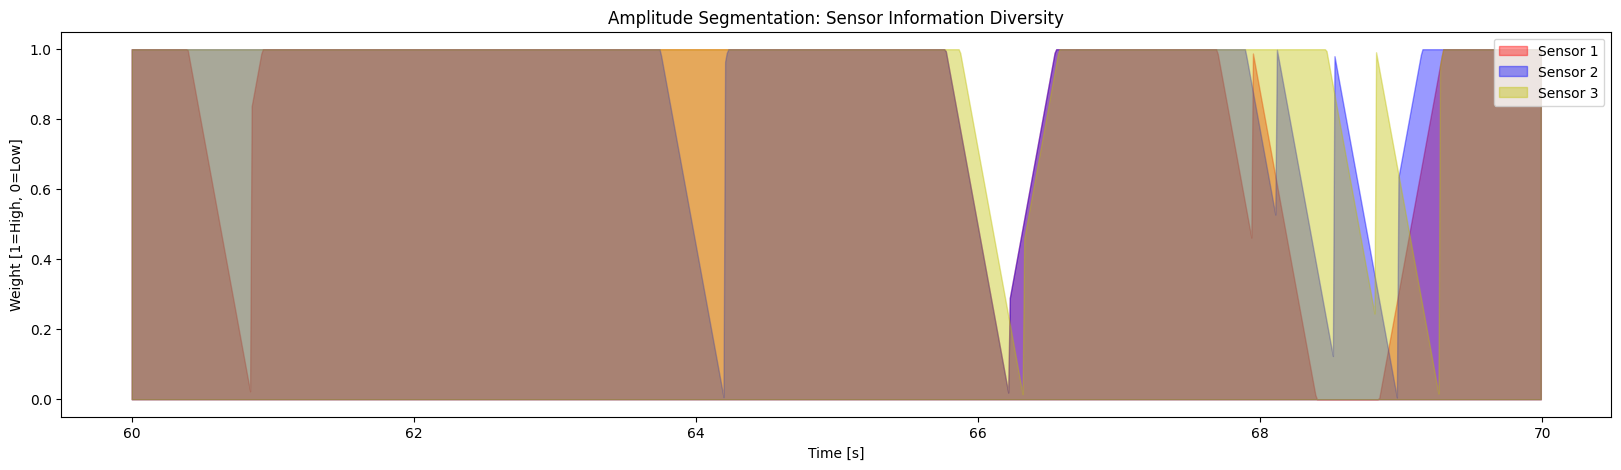

In [49]:
t0 = 60 * sr
t1 = 70 * sr
plt.figure(figsize=(20,5))
plt.title('Amplitude Segmentation: Sensor Information Diversity')
plt.fill_between(tt[t0:t1:500], C[0,t0:t1:500], 0, alpha=.4, color='r', label='Sensor 1')
plt.fill_between(tt[t0:t1:500], C[1,t0:t1:500], 0, alpha=.4, color='b', label='Sensor 2')
plt.fill_between(tt[t0:t1:500], C[2,t0:t1:500], 0, alpha=.4, color='y', label='Sensor 3')
plt.xlabel("Time [s]")
plt.ylabel("Weight [1=High, 0=Low]")
plt.legend()

In [50]:
print("Percent of noise per sensor:", ", ".join([f"{1 - tr.sum(c) / len(c):2.2%}" for c in C]))

Percent of noise per sensor: 13.37%, 3.16%, 3.92%


Use volume discriminator to separate high volume and low volume sounds (segmentation).

In [51]:
# Segmentation
X_high = X * C
iC = 1 - C
X_low = X * iC

X_low /= rms(X_low) * 10 # Standardize noise volume

X_noise = []
for i in range(3):
    x = X_low[i][iC[i] > .5] # Truncate silence in each noise sample
    x /= rms(x) * 10 # Normalize noise per sensor
    X_noise.append(x)

In [52]:
# Export each segment for evaluation
torchaudio.save('high_segment.wav', X_high, sr)
torchaudio.save('low_segment.wav', tr.unsqueeze(tr.cat(X_noise), 0), sr)

# 3. Crossed Noise Reduction
Cross apply noise samples. If the noise sample and clean sample come from the same sensor more of the noise is removed. Noise samples are applied to other sensors to a lessor degree.

In [53]:
X_clean = X_high.clone()

for i in range(3):
    # Cross apply each noise sample onto each vocal sample. Noise applied sequentially
    for j in range(3):
        X_clean[i] = tr.tensor(nr.reduce_noise(y=X_clean[i], y_noise=X_noise[j],
                                               sr=sr,
                                               prop_decrease=.9 if i == j else .75,
                                               n_std_thresh_stationary=.5,
                                               stationary=True))

# 4. Fusion
Weight sensors by RMS amplitude (volume) and put into moving average fusion.

In [54]:
W = tr.reshape(tr.sqrt(tr.mean(X_clean**2, axis=1)), (3,1))
W /= W.sum()
print(W)
print(X_clean.shape)
x_clean = moving_average(X_clean * W, 7)

tensor([[0.7085],
        [0.2845],
        [0.0069]])
torch.Size([3, 9595771])


# 5. Volume Leveling
Attempt volume regularization. i.e. making the quiet segments of the cleaned signal louder.

In [55]:
def soft_limit(x, L):
    # L = np.log10(L / 20)
    return 2 / (1 + tr.exp(-x / L)) - 1

print("Input RMS:", rms(x_clean))
x_clean = soft_limit(x_clean, .005)
x_clean = torchaudio.transforms.Vol(-25, 'db')(x_clean  / rms(x_clean))
print(rms(x_clean))
x_clean = torchaudio.functional.lowpass_biquad(x_clean, sr, 4000)

Input RMS: tensor(0.0007)
tensor(0.0555)


In [56]:
torchaudio.save('output_fused.wav', x_clean, sr, encoding="PCM_S", bits_per_sample=32)